# Project : AT&T Spam Detector 1/2
## Coding my own Recurrent Neural Network

In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf

# data cleaning / tokenizing
import re
import en_core_web_md
from spacy.lang.en.stop_words import STOP_WORDS

# text preprocessing
from keras.preprocessing import sequence

from keras.preprocessing.text import Tokenizer

# model building
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split

# plot lib
import matplotlib.pyplot as plt

# score handling
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('src/spam.csv', encoding = "ISO-8859-1")

### Exploratory Data Analysis

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])


Number of rows : 5572

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

### Let's take a look at the target (label) distribution

In [5]:
df.v1.value_counts()


ham     4825
spam     747
Name: v1, dtype: int64

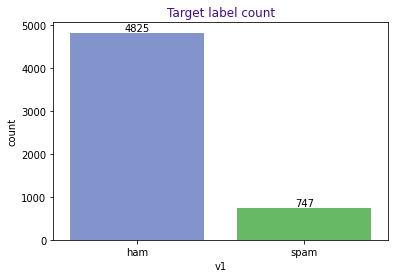

In [6]:
ax = sns.countplot(df['v1'], palette=['#778cd8',"#59c758"])
for container in ax.containers:
    ax.bar_label(container)
plt.title('Target label count', fontdict={'color':'#410d88'})
plt.show()


## Data Cleaning

In [7]:
# With 0.99 percent of missing values, I will remove these 3 columns :
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

# I will rename main columns with relevant names 
# I will replace the labels by 0(ham) and 1(spam)
df = df.rename(columns={"v1":"label", "v2":"sms_content"})
df['label'] = df['label'].map( {'spam': 1, 'ham': 0} )
df.head()

,label,sms_content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df['word_count'] = df['sms_content'].apply(lambda x : len(x.split(' ')))

In [9]:
df.groupby('label')['word_count'].agg(['count', 'mean', 'median'])

,count,mean,median
label,,,
0,4825,14.323938,11.0
1,747,23.892905,25.0


In [10]:
df.head()

,label,sms_content,word_count
0,0,"Go until jurong point, crazy.. Available only ...",20
1,0,Ok lar... Joking wif u oni...,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,0,U dun say so early hor... U c already then say...,11
4,0,"Nah I don't think he goes to usf, he lives aro...",13


In [11]:
df['word_count'].max()

171

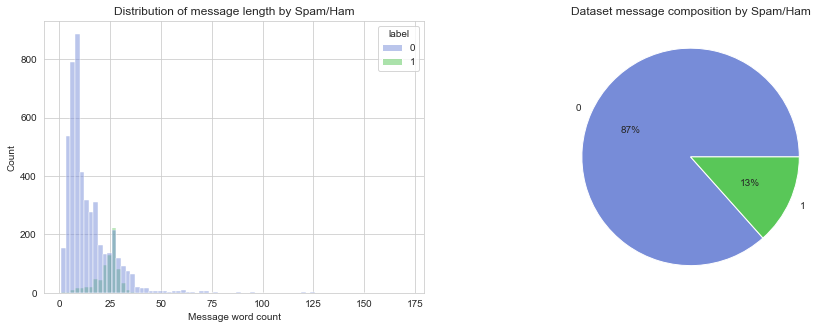

In [12]:
# Plot message length by spam/ham

#df['label'] = pd.Categorical(df['label'], ['1','0'])
sns.set_style("whitegrid")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
sns.histplot(data=df, 
             x="word_count",
             hue="label",
             bins=75,
             ax=ax[0],
             palette=['#778cd8',"#59c758"],
             legend=True).set_title('Distribution of message length by Spam/Ham')
ax[0].set_xlabel('Message word count')
ax[0].set_ylabel('Count')

ax[1].pie(df.label.value_counts(normalize=True), 
            labels = ['0','1'], 
            autopct='%0.f%%', 
            colors=['#778cd8',"#59c758"]
            )
ax[1].set_title('Dataset message composition by Spam/Ham')
# plt.savefig('images/eda.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

### Preprocessing data (step 1) - Encoding clean_content:
- **lemmatizing** to keep only the most important words on the good form.


*lemmatization* 

In [13]:
nlp = en_core_web_md.load()

In [14]:
df["clean_content"] = df["sms_content"].apply(
    lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'")
    )

df["clean_content"] = df["clean_content"].apply(
    lambda x: x.replace(" +"," ").lower().strip()
    )

df["clean_content"] = df["clean_content"].apply(
    lambda x: " ".join([token.lemma_ for token in nlp(x) \
    if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)])
    )

In [15]:
df.head()

,label,sms_content,word_count,clean_content
0,0,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,6,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,11,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",13,nah think usf live


### Preprocessing data (step2) :
- Train / Val splitting
- **tokenizing** (It means that we are going to assign a unique number to each word. It's necessary for the neural network to interpret the input).
- **Padding** (all sequences must have the same length).

In [16]:
X = df['clean_content']
y = df['label']

In [17]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(X, y, test_size=0.3)

In [18]:
max_words = 5000
max_len = 150

tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(xtrain)
tokenizer.fit_on_texts(xval)

sequences_train = tokenizer.texts_to_sequences(xtrain)
sequences_val = tokenizer.texts_to_sequences(xval)

sequences_padded_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_len)
sequences_padded_val = tf.keras.preprocessing.sequence.pad_sequences(sequences_val, maxlen=max_len)

In [19]:
print(sequences_train[:1])
print(sequences_padded_train[:1])

[[10, 103, 561, 1454, 2369, 3624, 1248, 312, 10, 3625, 3626, 10, 3627, 461, 1455, 3628]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   10  103  561 1454 2369 3624
  1248  312   10 3625 3626   10 3627  461 1455 3628]]


### Building my Deep Learning Model

##### Define my Recurrent Neural Network with an embedding layer: 
- embedding is efficient for text data
- RNN handle text sequencies and give some weight to each important word

In [20]:
vocab_size = tokenizer.num_words
embedding_dim=64 # the dimensionality of the representation space

model = tf.keras.Sequential([
                              
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_shape=[max_len],name="embedding"),
    LSTM(units=64, return_sequences=True), # maintains the sequential nature
    LSTM(units=32, return_sequences=False), # returns the last output
    Dense(16, activation='relu'), # a dense layer
    Dense(1, activation='sigmoid') # the prediction layer

])

# print the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 64)           320064    
                                                                 
 lstm (LSTM)                 (None, 150, 64)           33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 366,049
Trainable params: 366,049
Non-trainable params: 0
_________________________________________________________________
None


#### According to imbalanced target, I will try to add some weight in this RNN

In [21]:
df['label'].value_counts()

0    4825
1     747
Name: label, dtype: int64

In [22]:
weights = 1/(df["label"]).value_counts()
weights = weights * len(df)/5
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.23096373056994818, 1: 1.491834002677376}

In [23]:
# compile the model
optimizer= tf.keras.optimizers.Adam()

model.compile(  optimizer=optimizer, 
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                metrics=[tf.keras.metrics.BinaryAccuracy()]
            )

In [24]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# fit the model
history = model.fit(sequences_padded_train,
                    ytrain,
                    batch_size=64,
                    epochs=20,
                    validation_split=0.2,
                    class_weight=weights,
                    callbacks=[early_stop]
                    )

Epoch 1/20
49/49 [==============================] - 23s 324ms/step - loss: 0.1962 - binary_accuracy: 0.8035 - val_loss: 0.2574 - val_binary_accuracy: 0.9538
Epoch 2/20
49/49 [==============================] - 14s 284ms/step - loss: 0.0589 - binary_accuracy: 0.9788 - val_loss: 0.1131 - val_binary_accuracy: 0.9718
Epoch 3/20
49/49 [==============================] - 14s 295ms/step - loss: 0.0203 - binary_accuracy: 0.9917 - val_loss: 0.0790 - val_binary_accuracy: 0.9795
Epoch 4/20
49/49 [==============================] - 14s 278ms/step - loss: 0.0131 - binary_accuracy: 0.9962 - val_loss: 0.0793 - val_binary_accuracy: 0.9795
Epoch 5/20
49/49 [==============================] - 14s 296ms/step - loss: 0.0092 - binary_accuracy: 0.9984 - val_loss: 0.0833 - val_binary_accuracy: 0.9782
Epoch 5: early stopping


In [25]:
ypred_train = (model.predict(sequences_padded_train) > 0.5).astype("int32")
ypred_val = (model.predict(sequences_padded_val) > 0.5).astype("int32")

53/53 [==============================] - 5s 84ms/step


In [26]:
print(f"accuracy score on train set : {accuracy_score(ytrain, ypred_train)}")
print(f"accuracy score on validation set : {accuracy_score(yval, ypred_val)}")

accuracy score on train set : 0.9938461538461538
accuracy score on validation set : 0.9748803827751196


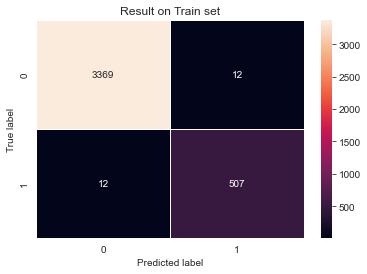

In [27]:
mtx = confusion_matrix(ytrain, ypred_train)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Train set')
plt.show()


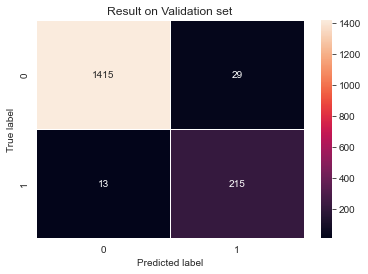

In [28]:
mtx = confusion_matrix(yval, ypred_val)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Validation set')
plt.show()

#### Take a look at the **history** recorded by my model, convergence sounds good.

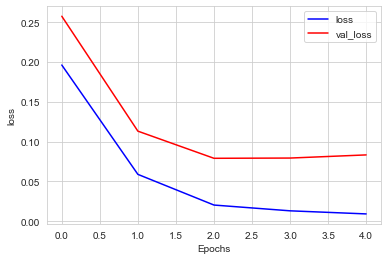

In [29]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b", label='loss')
plt.plot(history.history["val_loss"], color="r", label='val_loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(loc="upper right")
plt.show()


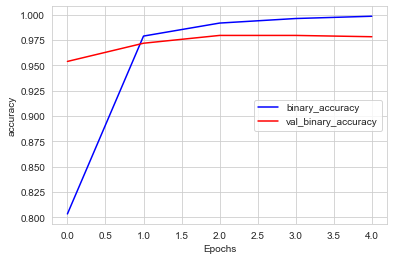

In [30]:
# Visualization of accuracy training 
plt.plot(history.history["binary_accuracy"], color="b", label='binary_accuracy')
plt.plot(history.history["val_binary_accuracy"], color="r", label='val_binary_accuracy')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend(loc="right")
plt.show()

### Optionnal : Saving model and history

In [31]:
# model.save("models_saved/model_lstm.h5")

In [32]:
# import json
# json.dump(model.history.history, open("models_saved/LSTM_history.json", 'w'))

### Conclusion :
- These results of this baseline are already very good
- We might try to increase the number of layers : LSTM, dropout, batchnormalization, ...
- We might try to change weights values
- We might try to change "maxwords" and "maxlen" to improve results and time computing
- Nevertheless, I will try transfer learning --> take a look at the Notebook 2/2